In [11]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split


import time
import pickle
from collections import Counter

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset3/main/weatherAUS.csv')

In [13]:
df.shape

(8425, 23)

In [14]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [15]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [16]:
df.isnull().sum()

Date                0
Location            0
MinTemp            75
MaxTemp            60
Rainfall          240
Evaporation      3512
Sunshine         3994
WindGustDir       991
WindGustSpeed     991
WindDir9am        829
WindDir3pm        308
WindSpeed9am       76
WindSpeed3pm      107
Humidity9am        59
Humidity3pm       102
Pressure9am      1309
Pressure3pm      1312
Cloud9am         2421
Cloud3pm         2455
Temp9am            56
Temp3pm            96
RainToday         240
RainTomorrow      239
dtype: int64

In [17]:
plt.figure(figsize=(10,8))
sns.countplot(df['RainTomorrow'])
plt.title('Whether There is RainTomorrow or Not')
plt.show()

ValueError: could not convert string to float: 'No'

<Figure size 1000x800 with 0 Axes>

In [18]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [feature for feature in df.columns if feature not in numerical_features]
binary_categorical_features = [feature for feature in categorical_features if len(df[feature].unique()) <=3]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

Numerical Features Count 16
Discrete features Count 2
Continuous features Count 14
Categorical features Count 7
Binary Categorical features Count 2


In [19]:
def generate_distribution_plot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.distplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

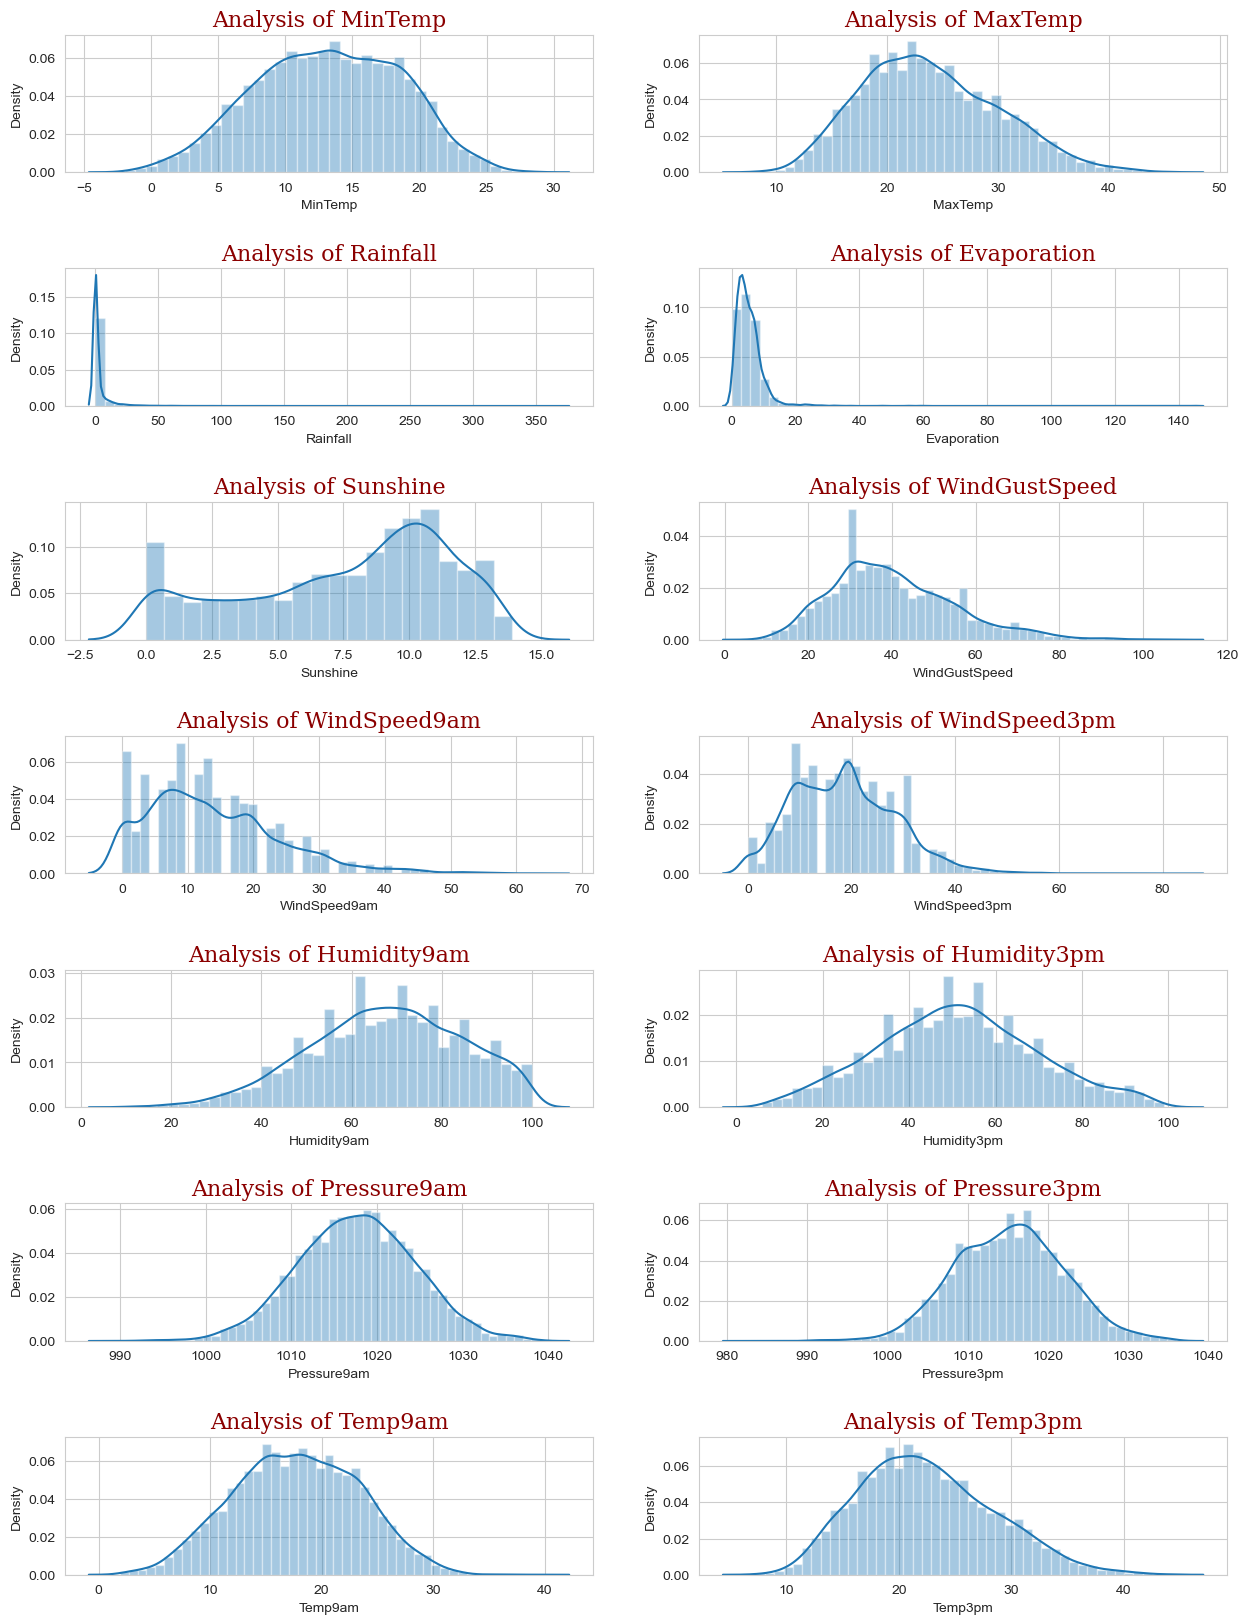

In [20]:
generate_distribution_plot(df, continuous_features)

In [21]:
sample_imputation_features = [col for col in df.columns if (df.isnull().sum()[col] > 50000)]

In [22]:
def randomsampleimputation(df, columns):
    data = df.copy()
    for column in columns:
        random_sample = data[column].dropna().sample(data[column].isnull().sum(),random_state=2022)
        random_sample.index = data[data[column].isnull()].index
        data.loc[data[column].isnull(),column] = random_sample
    return data

In [23]:
f = randomsampleimputation(df,sample_imputation_features)

In [24]:
missing_values_numeric_features  = [col for col in df.columns if (df.isnull().sum()[col] > 0) & (df[col].dtypes != 'object')]


In [25]:
def impute_means(df, missing_values_columns):
    data = df.copy()
    '''Filling missing values with mean'''
    for col in missing_values_columns:
        data[col] = data[col].fillna(data[col].mean())
        
    return data

In [26]:
df = impute_means(df,missing_values_numeric_features)

In [27]:
df.isnull().sum()

Date               0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir      991
WindGustSpeed      0
WindDir9am       829
WindDir3pm       308
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday        240
RainTomorrow     239
dtype: int64

In [28]:
def plot_boxplot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.boxplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

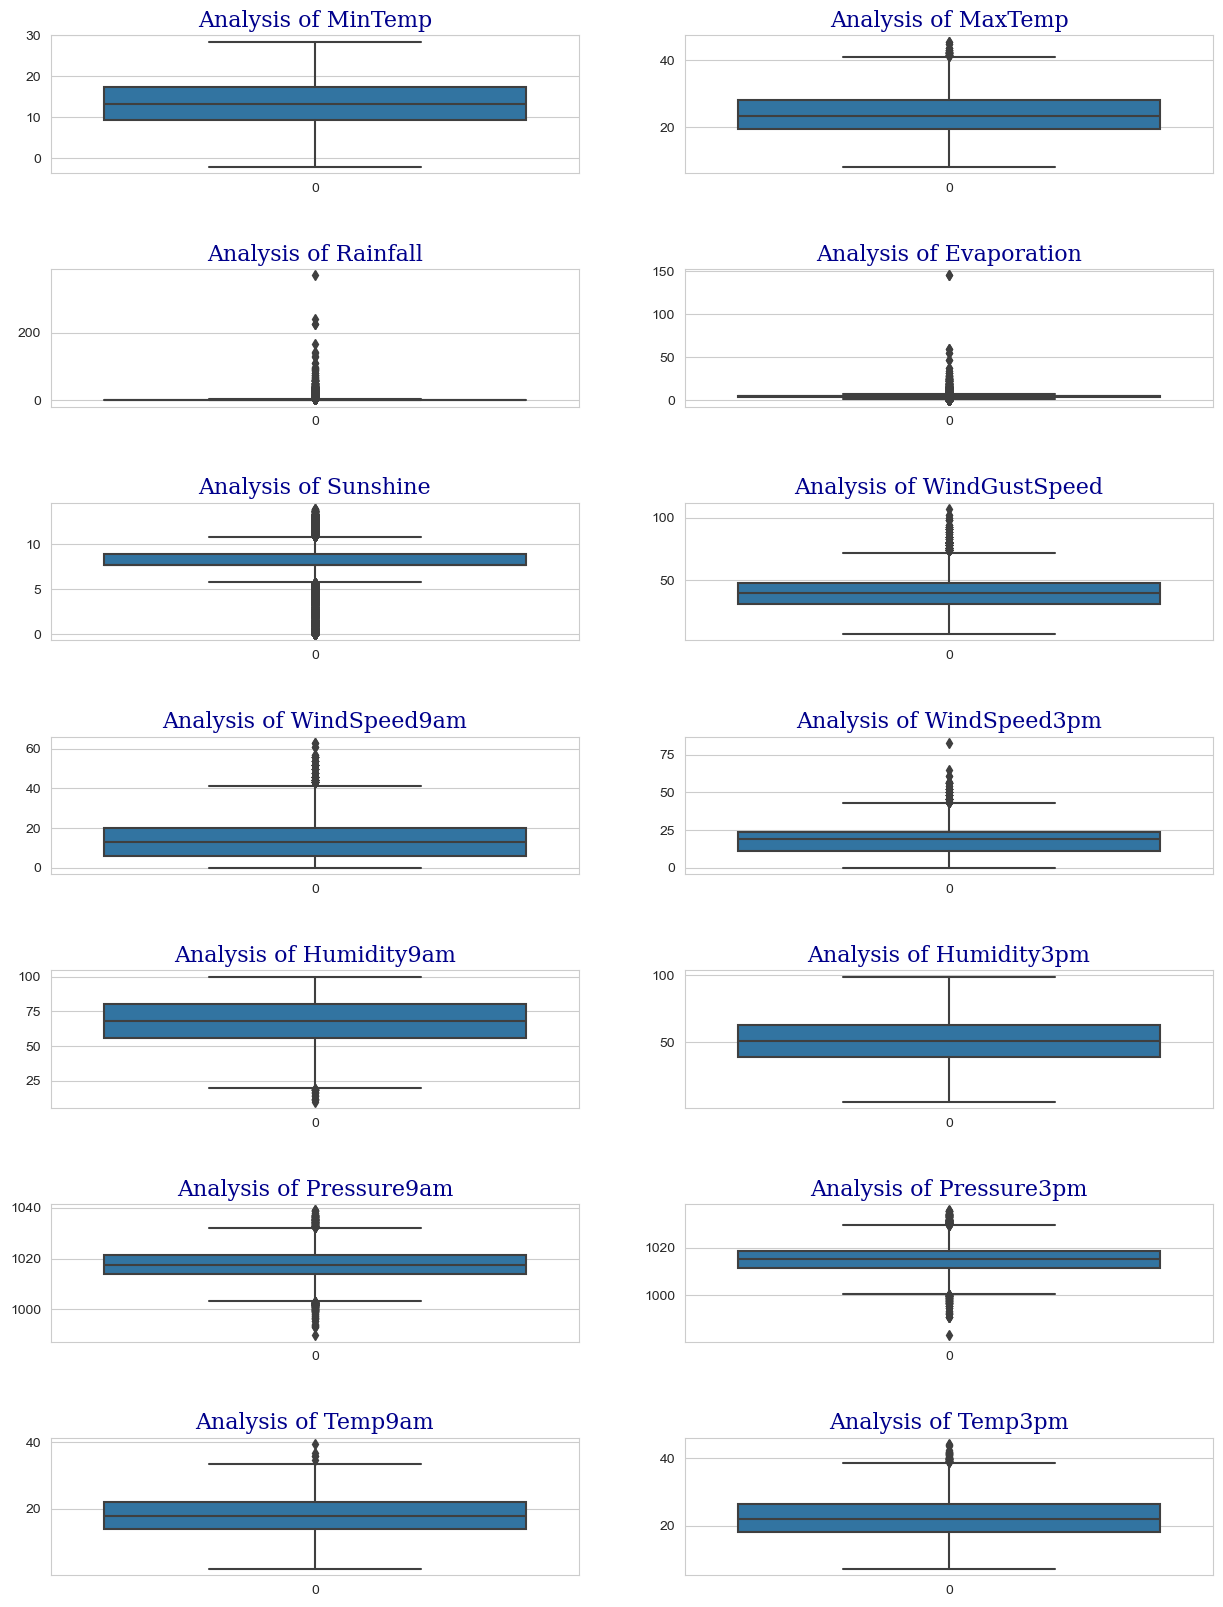

In [29]:
plot_boxplot(df, continuous_features)

In [30]:
outliers_features = [feature for feature in continuous_features if feature not in ['Sunshine','Humidity3pm']]
print(outliers_features)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [31]:
def remove_outliers(df,outliers_features):
    # create copy of dataframe
    
    data = df.copy()
    
    for feature in data[outliers_features].columns:
        Q3 = data[feature].quantile(0.75)
        Q1 = data[feature].quantile(0.25)
        IQR = Q3 - Q1
        lower_limit = round(Q1 - 1.5 * IQR)
        upper_limit = round(Q3 + 1.5 * IQR)
        data.loc[data[feature]>= upper_limit,feature] = upper_limit
        data.loc[data[feature]<=lower_limit,feature] = lower_limit
#         data = data[(data[feature] < upper_limit) & (data[feature] > lower_limit)]
    return data

In [32]:
df = remove_outliers(df,outliers_features)

In [33]:
df.shape

(8425, 23)

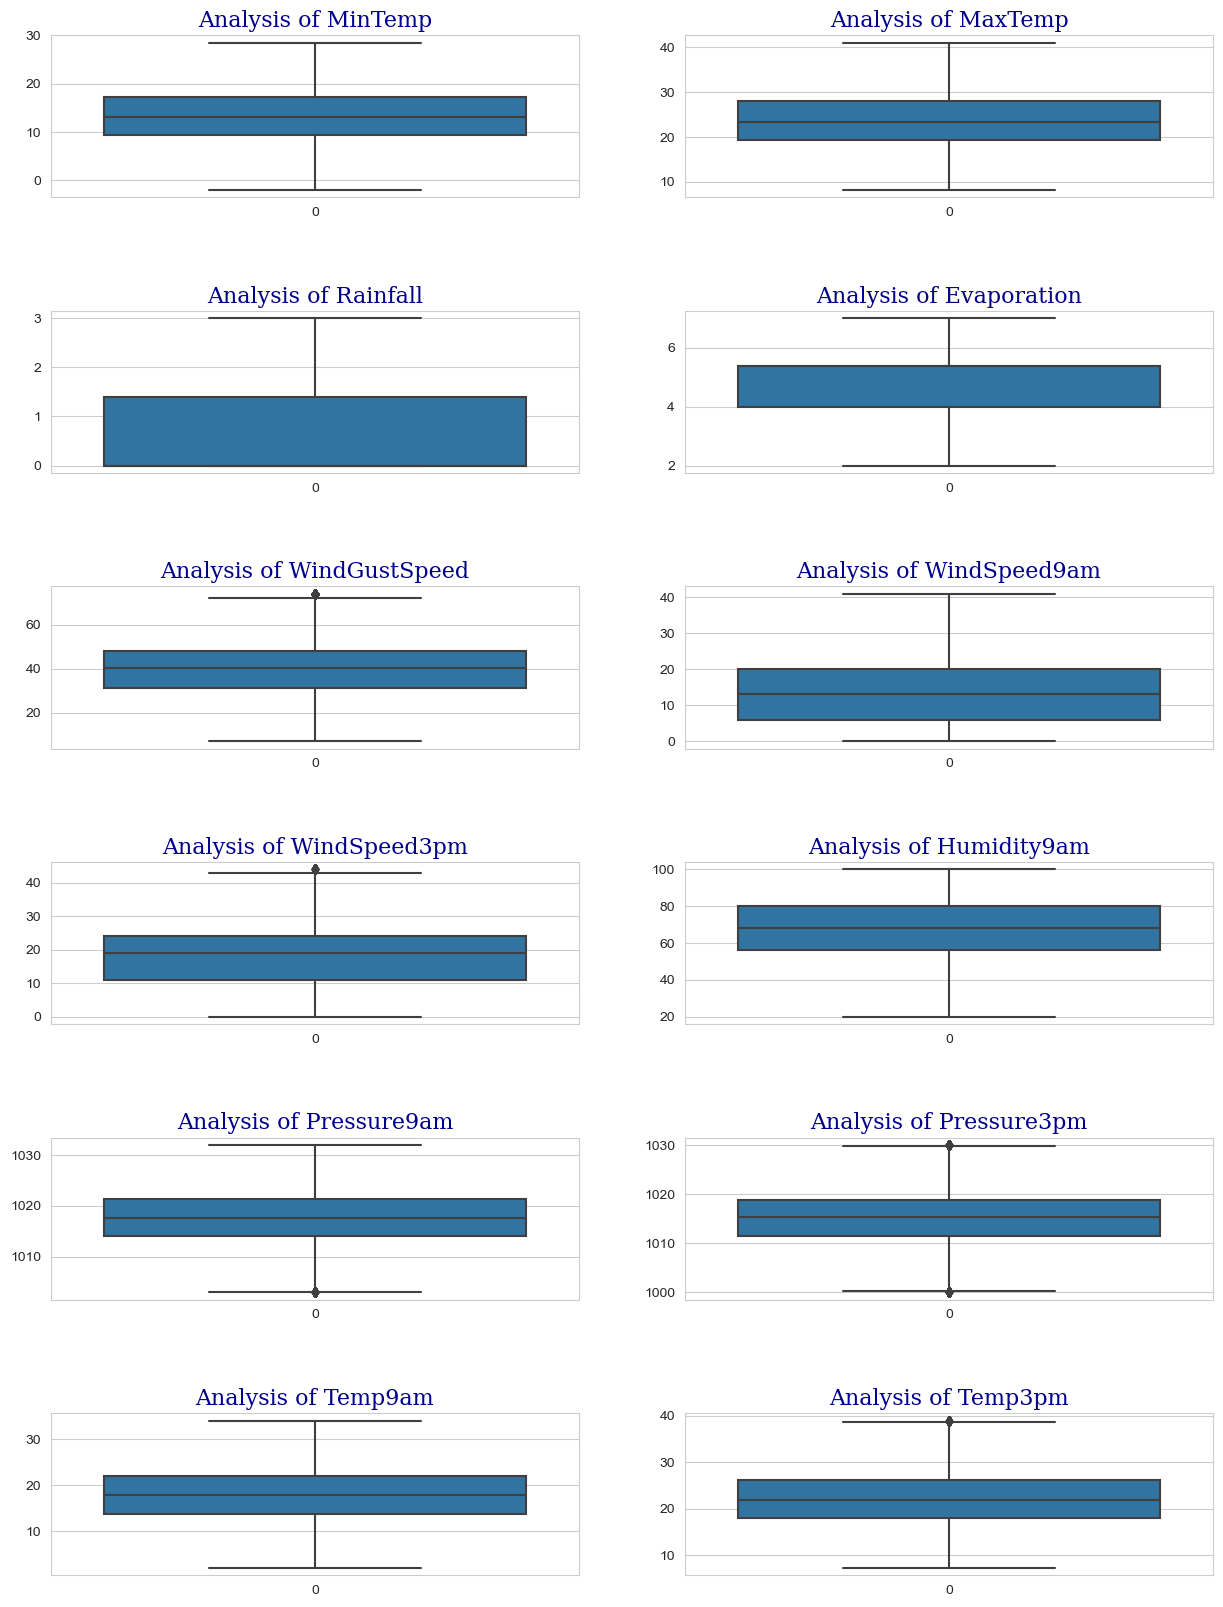

In [34]:
plot_boxplot(df, outliers_features)

In [35]:
# Raintoday
df['RainToday'] = df['RainToday'].fillna('No')
# Raintomorrow
df['RainTomorrow'] = df['RainTomorrow'].fillna('No')

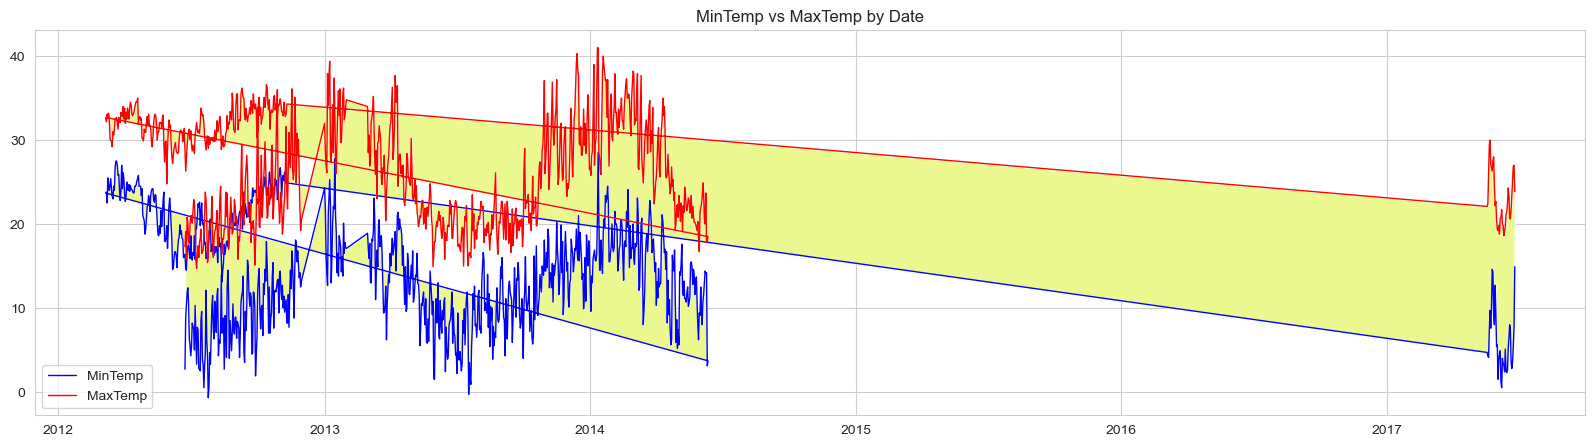

In [36]:
df["Date"] = pd.to_datetime(df["Date"])
# using data from last 3 years.
df_last_3_years = df.iloc[-950:,:]
plt.figure(figsize=[20,5])
plt.plot(df_last_3_years['Date'],df_last_3_years['MinTemp'],color='blue',linewidth=1, label= 'MinTemp')
plt.plot(df_last_3_years['Date'],df_last_3_years['MaxTemp'],color='red',linewidth=1, label= 'MaxTemp')
plt.fill_between(df_last_3_years['Date'],df_last_3_years['MinTemp'],df_last_3_years['MaxTemp'], facecolor = '#EBF78F')
plt.title('MinTemp vs MaxTemp by Date')
plt.legend(loc='lower left')
plt.show()

In [37]:
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day

# We don't need date feature anymore for model building
df.drop('Date', axis=1, inplace=True)

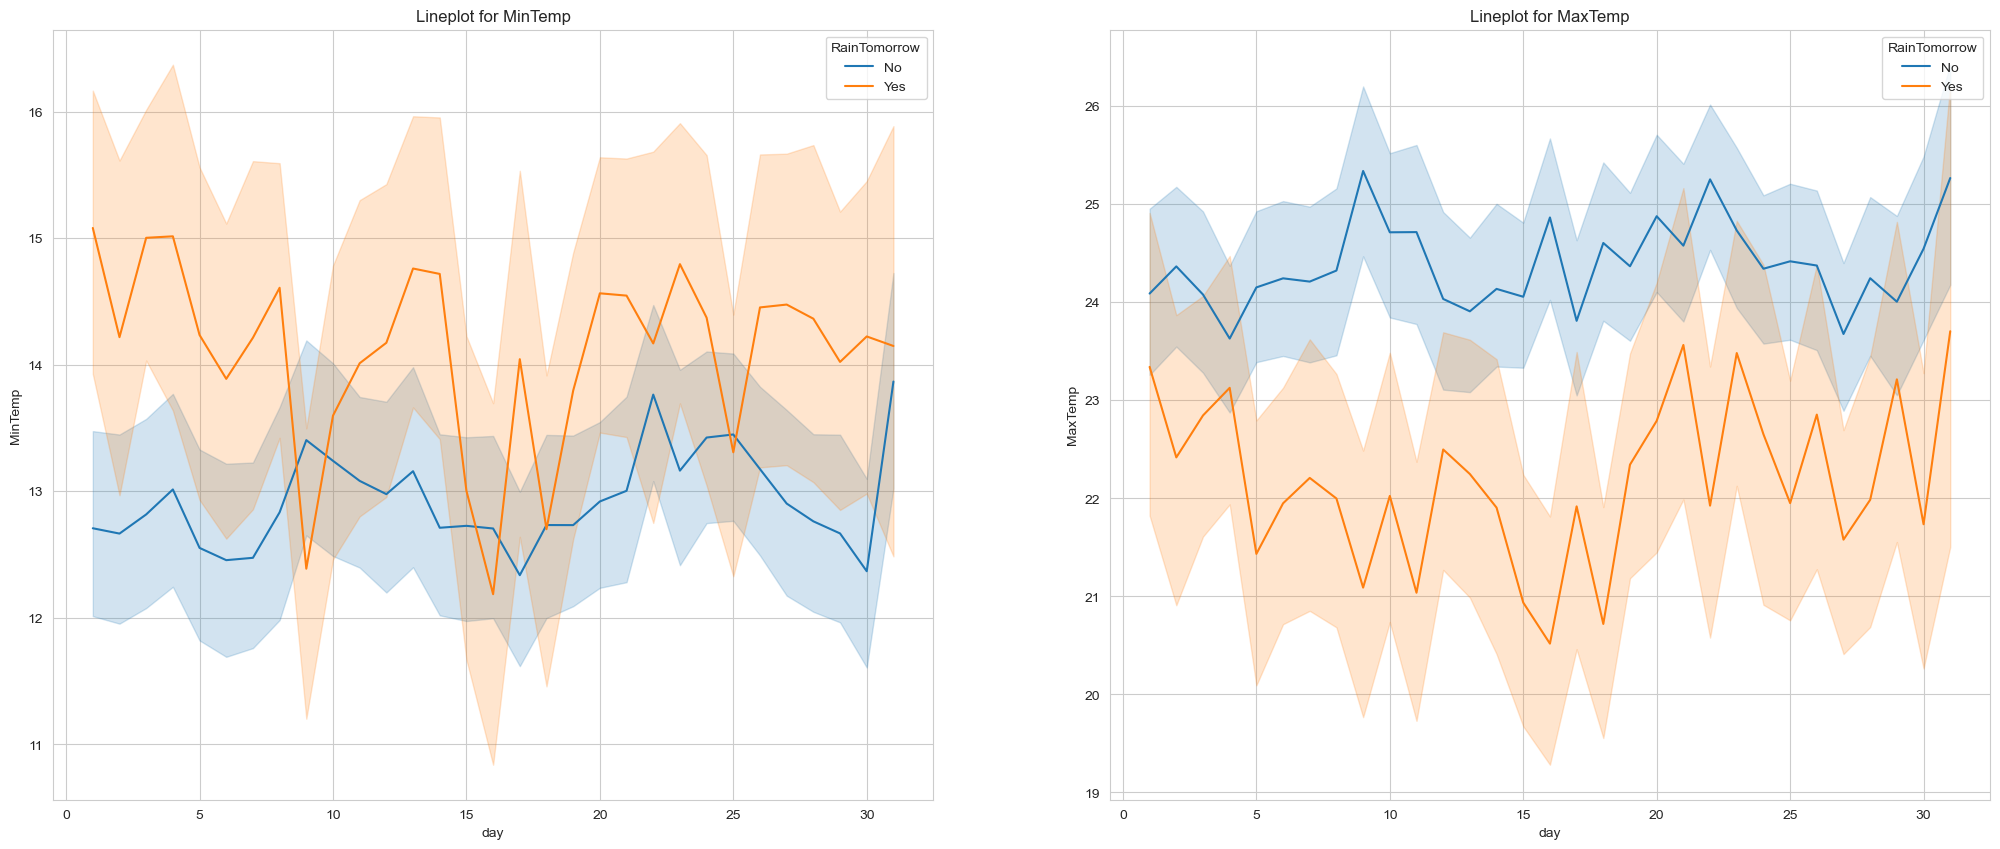

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Mintemp
sns.lineplot(ax=axes[0],x="day",y="MinTemp",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for MinTemp')
# Maxtemp
sns.lineplot(ax=axes[1],x="day",y="MaxTemp",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for MaxTemp')
plt.show()

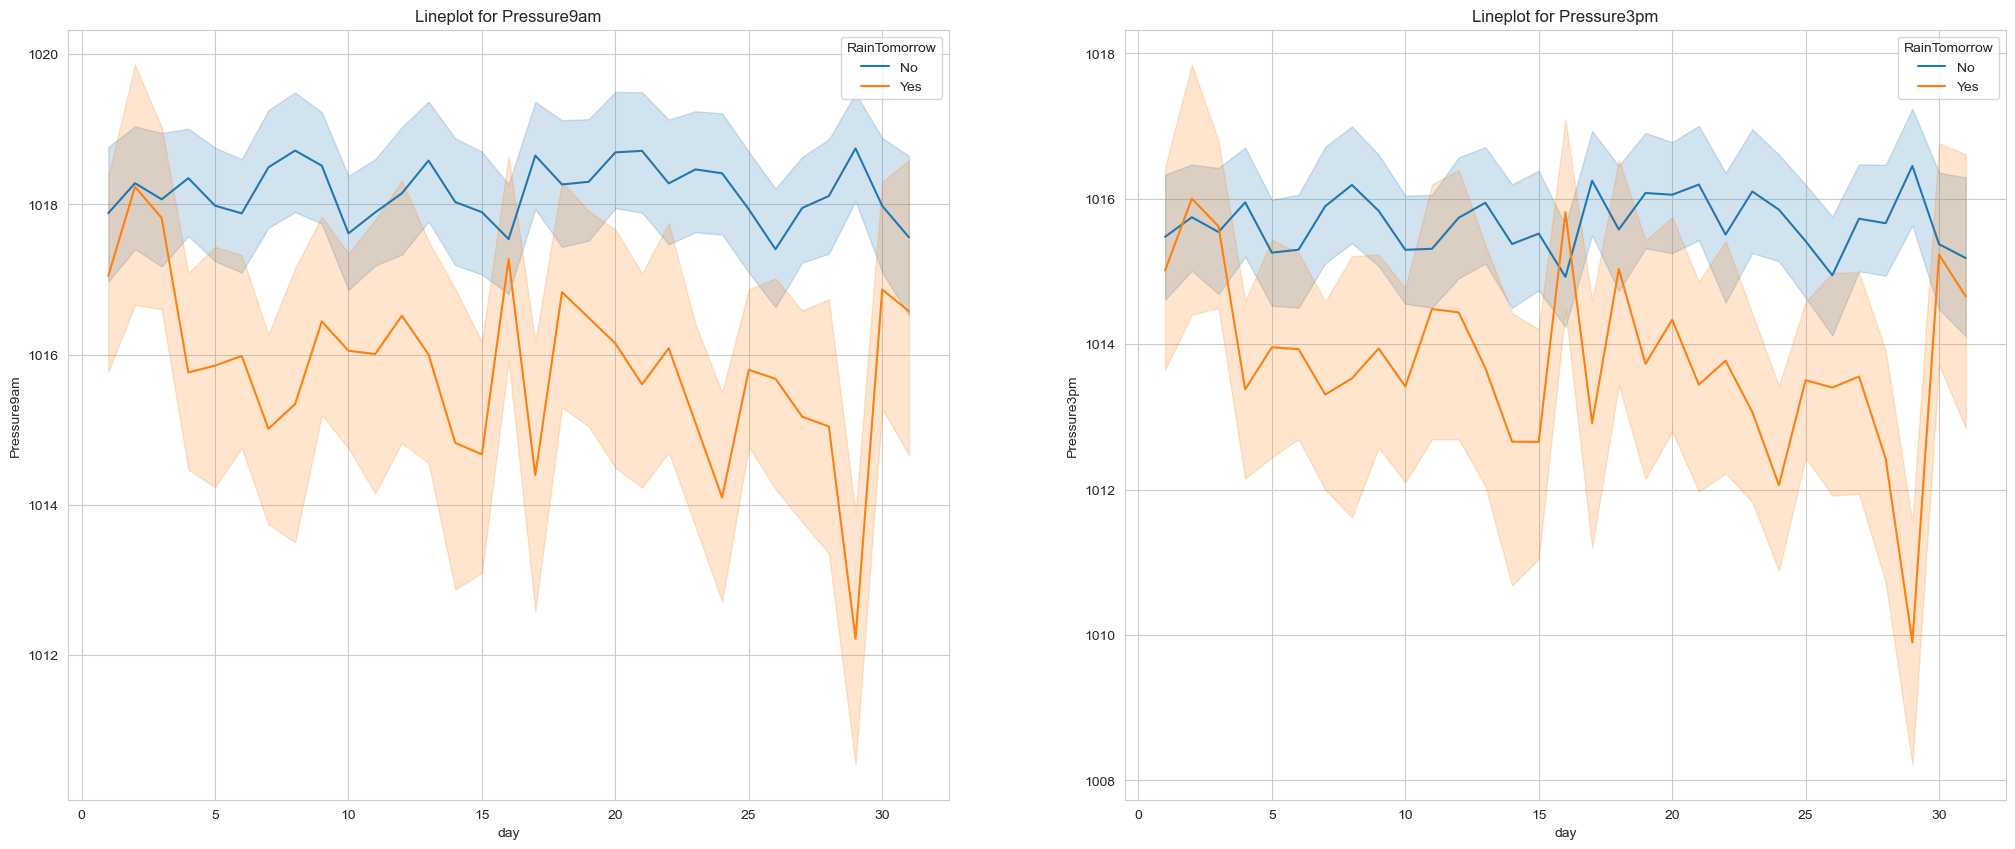

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Pressure9am
sns.lineplot(ax=axes[0],x="day",y="Pressure9am",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for Pressure9am')
# Pressure3pm
sns.lineplot(ax=axes[1],x="day",y="Pressure3pm",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for Pressure3pm')
plt.show()

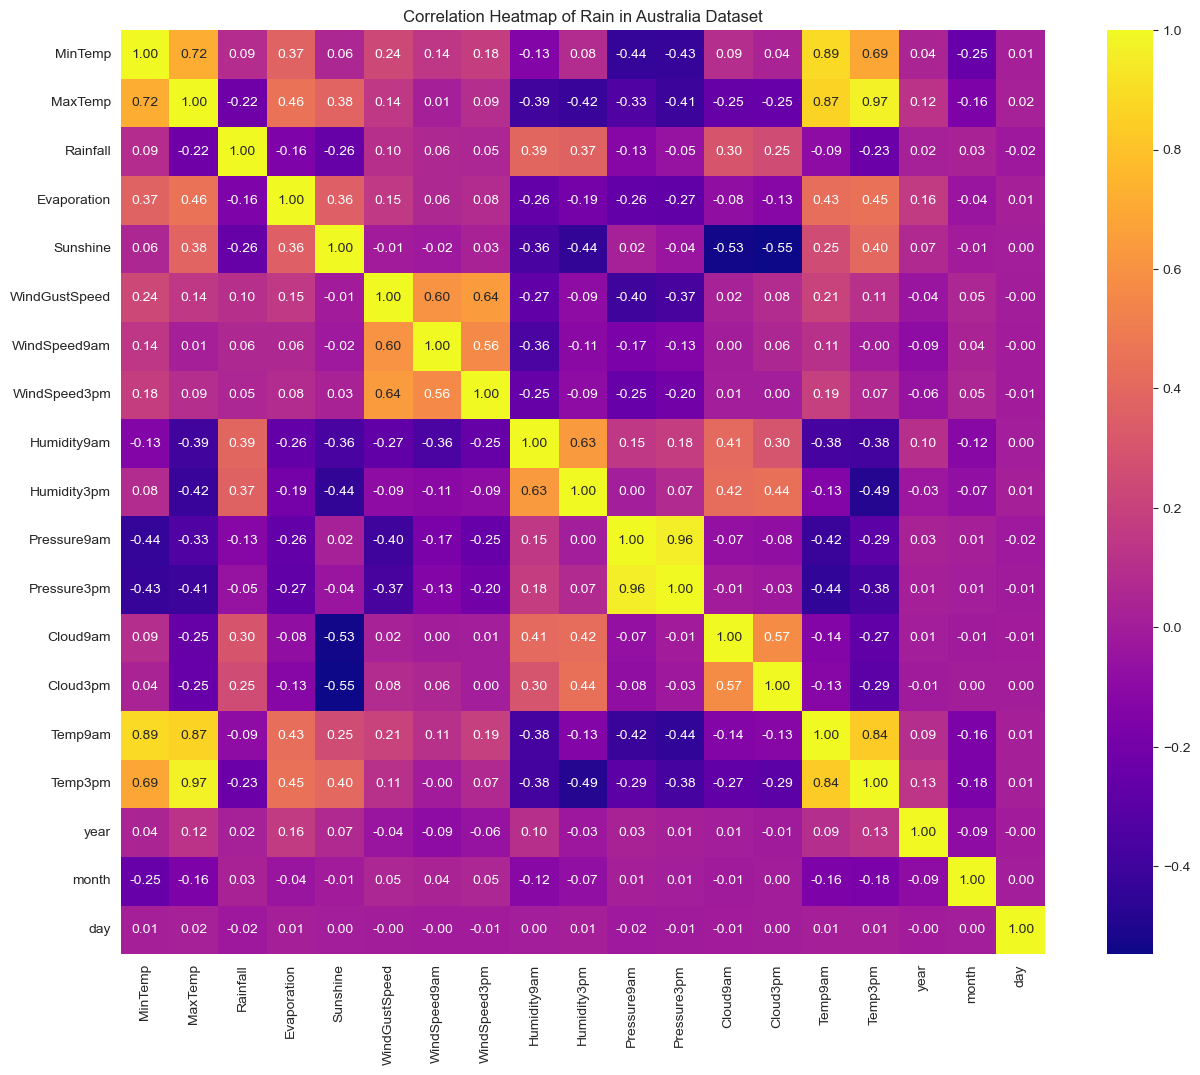

In [40]:
corrmat = df.corr()

# heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', linecolor='white', cmap='plasma')    
plt.title('Correlation Heatmap of Rain in Australia Dataset')
plt.show()

In [41]:
le = LabelEncoder()

label_encoder_features = binary_categorical_features

for col in label_encoder_features:
    df[col] = le.fit_transform(df[col])

In [42]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,5.389395,7.632205,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503183,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,5.389395,7.632205,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.566622,4.503183,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,5.389395,7.632205,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.566622,2.000000,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,5.389395,7.632205,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.566622,4.503183,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,5.389395,7.632205,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0,2008,12,5


In [ ]:
ategorical_columns = [col for col in df.columns if df.dtypes[col] == 'object']
print('Categorical Features are : ',categorical_columns)

In [44]:
def onehot_encoder(df, cols):
    data = df.copy()
    for col in cols:
        dummies = pd.get_dummies(data[col],drop_first=True,prefix=col)
        # concatenating dummies and original dataframe
        data = pd.concat([data, dummies], axis=1)
        
        # dropping original columns for which encoding is applied.
        data.drop(col, axis=1,inplace=True)
    return data

In [45]:
df = onehot_encoder(df,categorical_columns)

NameError: name 'categorical_columns' is not defined

In [46]:
df.shape

(8425, 25)

In [47]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,5.389395,7.632205,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503183,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,5.389395,7.632205,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.566622,4.503183,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,5.389395,7.632205,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.566622,2.000000,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,5.389395,7.632205,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.566622,4.503183,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,5.389395,7.632205,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0,2008,12,5


In [48]:
df.isnull().sum().sum()

2128

In [49]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)